In [1]:
%load_ext autoreload
%autoreload 2

# Network Classes

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.models as models

class EmbeddingNet(nn.Module):
    def __init__(self, resnet = None):
        super(EmbeddingNet, self).__init__()
        if resnet is None:
            resnet = models.resnet18(pretrained=True)
            
        self.resnet = resnet
        self.resnet_layer = self.resnet._modules.get('avgpool')
        self.resnet.eval()

        self.fc = nn.Sequential(nn.Linear(64 * 8, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)
                                )
    def forward(self, x):
        output = self.get_resnet_embedding(x)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)
    
    def get_resnet_embedding(self, x):
        embedding = torch.cuda.FloatTensor(x.shape[0],512,1,1).fill_(0)
        def copy(m, i, o):
            embedding.copy_(o.data)
        hook = self.resnet_layer.register_forward_hook(copy)
        self.resnet(x)
        hook.remove()
        return embedding.view(embedding.size()[0], -1)
    
class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.nonlinear = nn.PReLU()
        self.fc1 = nn.Linear(2, n_classes)

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        scores = F.log_softmax(self.fc1(output), dim=-1)
        return scores

    def get_embedding(self, x):
        return self.nonlinear(self.embedding_net(x))


# Dataset Classes

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

In [3]:
from torchvision import transforms
from folder import ImageFolder

classes = ['cat', 'coast', 'dog', 'food', 'fruit', 'goat', 'monks', 'person', 'shops', 'vehicle']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
])

data = ImageFolder('./Flickr', transform=transform, classes=classes)

In [4]:
import numpy as np 
import torch

n = len(data)
n_classes = len(data.classes)
indices = list(range(n))
split = n * 20 // 100

test_idx = np.random.choice(indices, size=split, replace=False)
train_idx = list(set(indices) - set(test_idx))
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)

In [5]:
print("{} images encompassing {} classes".format(n, n_classes))

3721 images encompassing 10 classes


## Common setup

In [14]:
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [9]:
# Set up data loaders
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(data, sampler=train_sampler, batch_size=batch_size, **kwargs)
test_loader = torch.utils.data.DataLoader(data, sampler=test_sampler, batch_size=batch_size, **kwargs)

In [10]:
# Set up the network and training parameters
from metrics import AccumulatedAccuracyMetric
import torchvision.models as models

embedding_net = EmbeddingNet(resnet = models.resnet18(pretrained=True))
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 20

In [12]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])


Train: [0/3721 (0%)]	Loss: 2.327379	Accuracy: 11.71875
Train: [2560/3721 (83%)]	Loss: 3.091658	Accuracy: 11.160714285714286
Epoch: 1/20. Train set: Average loss: 2.9699	Accuracy: 10.81625797783003
Epoch: 1/20. Validation set: Average loss: 2.3557	Accuracy: 12.231182795698924
Train: [0/3721 (0%)]	Loss: 2.349702	Accuracy: 11.71875
Train: [2560/3721 (83%)]	Loss: 2.328812	Accuracy: 11.644345238095237
Epoch: 2/20. Train set: Average loss: 2.3219	Accuracy: 11.588847833389318
Epoch: 2/20. Validation set: Average loss: 2.2751	Accuracy: 14.381720430107526
Train: [0/3721 (0%)]	Loss: 2.281841	Accuracy: 11.71875
Train: [2560/3721 (83%)]	Loss: 2.234764	Accuracy: 15.25297619047619
Epoch: 3/20. Train set: Average loss: 2.2388	Accuracy: 15.082297615048708
Epoch: 3/20. Validation set: Average loss: 2.1765	Accuracy: 15.725806451612904
Train: [0/3721 (0%)]	Loss: 2.198431	Accuracy: 16.40625
Train: [2560/3721 (83%)]	Loss: 1.964203	Accuracy: 24.62797619047619
Epoch: 4/20. Train set: Average loss: 1.9475	Acc

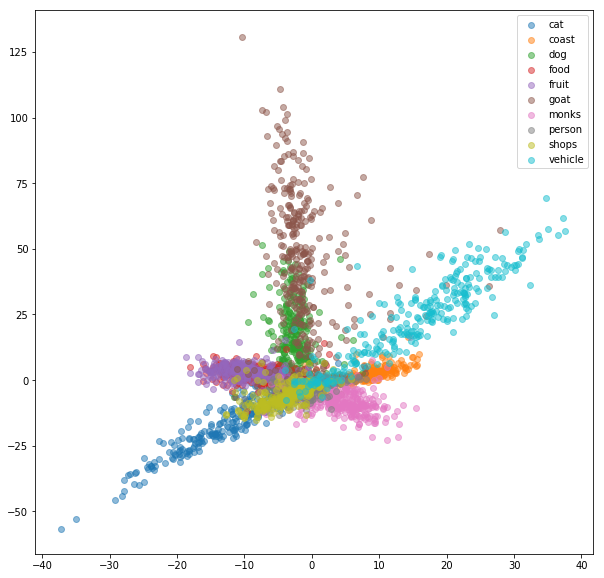

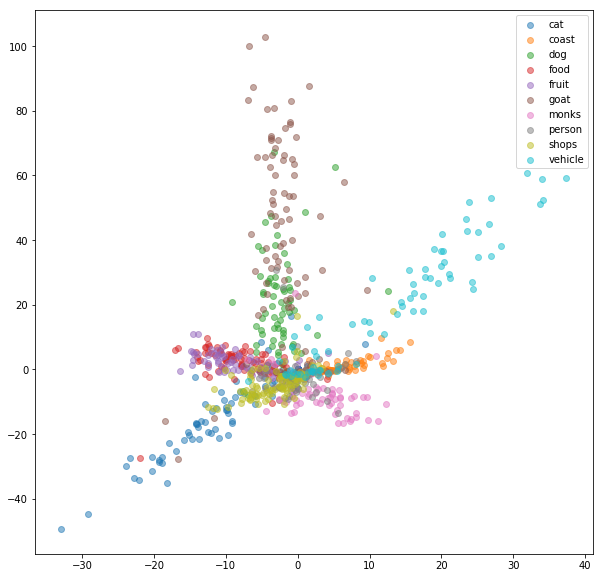

In [15]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

While the embeddings look separable (which is what we trained them for), they don't have good metric properties. They might not be the best choice as a descriptor for new classes.

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

In [42]:
classes = ['cat', 'coast', 'dog', 'food', 'fruit', 'goat', 'monks', 'person', 'shops', 'vehicle']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
])

data = ImageFolder('./Flickr', transform=transform, classes=classes)

In [45]:
from torch.utils.data import random_split
n = len(data)
n_classes = 10
split = int(n * 20 / 100)

train_dataset, test_dataset = random_split(data, [n-split,split])

In [46]:
# Build datasets
from datasets import SiameseNusWideDataset
siamese_train_dataset = SiameseNusWideDataset(train_dataset, test_dataset, transform = None, train = True)
siamese_test_dataset = SiameseNusWideDataset(train_dataset, test_dataset, transform = None, train = False)

In [47]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from losses import ContrastiveLoss

from networks import SiameseNet
margin = 1.
embedding_net = EmbeddingNet(resnet = models.resnet18(pretrained=True))
model = SiameseNet(embedding_net)
cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [48]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

Train: [0/2977 (0%)]	Loss: 0.198592	Accuracy: 50.78125
Epoch: 1/20. Train set: Average loss: 0.1243	Accuracy: 48.7739334900907
Epoch: 1/20. Validation set: Average loss: 0.1045	Accuracy: 48.11827956989247
Train: [0/2977 (0%)]	Loss: 0.108137	Accuracy: 50.78125
Epoch: 2/20. Train set: Average loss: 0.0957	Accuracy: 48.67316090023514
Epoch: 2/20. Validation set: Average loss: 0.0983	Accuracy: 49.193548387096776
Train: [0/2977 (0%)]	Loss: 0.085937	Accuracy: 50.390625
Epoch: 3/20. Train set: Average loss: 0.0904	Accuracy: 51.494793416190795
Epoch: 3/20. Validation set: Average loss: 0.0981	Accuracy: 50.0
Train: [0/2977 (0%)]	Loss: 0.093516	Accuracy: 49.21875
Epoch: 4/20. Train set: Average loss: 0.0902	Accuracy: 48.7739334900907
Epoch: 4/20. Validation set: Average loss: 0.0946	Accuracy: 49.05913978494624
Train: [0/2977 (0%)]	Loss: 0.085167	Accuracy: 48.828125
Epoch: 5/20. Train set: Average loss: 0.0898	Accuracy: 50.856567013772256
Epoch: 5/20. Validation set: Average loss: 0.0931	Accuracy

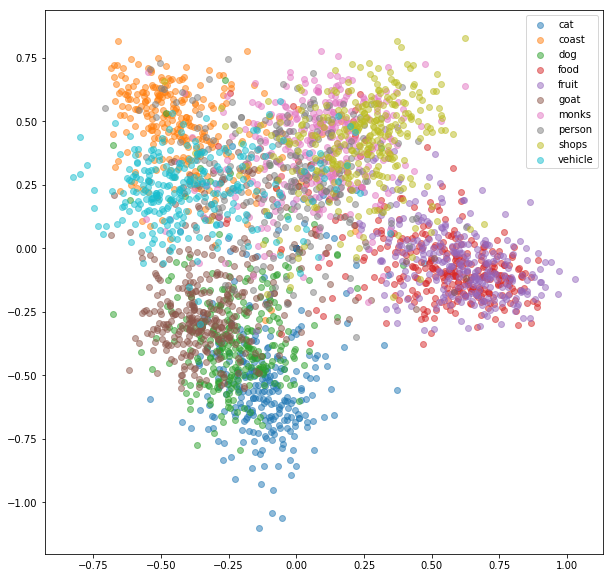

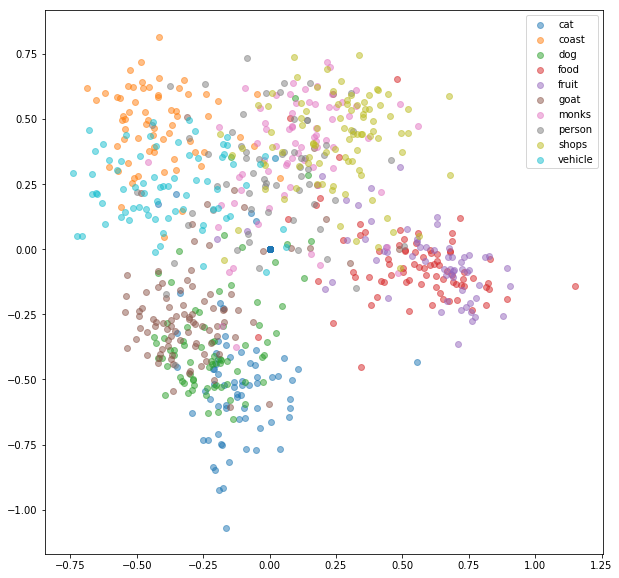

In [49]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

In [ ]:
train_embeddings_cl[0]

# Indexing for KNN


In [ ]:
print("HOHOHOH")

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [ ]:
# Set up data loaders
from datasets import TripletNusWideDataset

triplet_train_dataset = TripletNusWideDataset(train_dataset, test_dataset, transform = None, train = True)
triplet_test_dataset = TripletNusWideDataset(train_dataset, test_dataset, transform = None, train = False)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [ ]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

In [ ]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection

In [ ]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [ ]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

In [ ]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

## Online triplet selection

In [ ]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [ ]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

In [ ]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

In [ ]:
# display_emb_online, display_emb, display_label_online, display_label = train_embeddings_otl, train_embeddings_tl, train_labels_otl, train_labels_tl
display_emb_online, display_emb, display_label_online, display_label = val_embeddings_otl, val_embeddings_tl, val_labels_otl, val_labels_tl
x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

In [ ]:
x_lim = (np.min(train_embeddings_ocl[:,0]), np.max(train_embeddings_ocl[:,0]))
y_lim = (np.min(train_embeddings_ocl[:,1]), np.max(train_embeddings_ocl[:,1]))
plot_embeddings(train_embeddings_cl, train_labels_cl, x_lim, y_lim)
plot_embeddings(train_embeddings_ocl, train_labels_ocl, x_lim, y_lim)